# Examples for getting CML data and processing it

## Download open CML dataset from the Netherlands and convert to NetCDF

In [1]:
import opensense_data_downloader_and_transformer as oddt

In [2]:
oddt.download_overeem_2019_large_CML_data_Netherlands(
    local_path='overeem_2019_large_CML_data_Netherlands', 
    print_output=True,
)

to overeem_2019_large_CML_data_Netherlands/data.zip


('overeem_2019_large_CML_data_Netherlands/data.zip',
 <http.client.HTTPMessage at 0x1110fcb50>)

In [3]:
ds_overeem_2019 = oddt.transform_overeem_2019_large_CML_data_Netherlands(
    fn='overeem_2019_large_CML_data_Netherlands/data.zip', 
    nrows=1e6,
)

cml 295 has 342 duplicated entries from 684 rows.
cml 319 has 342 duplicated entries from 684 rows.
cml 341 has 342 duplicated entries from 684 rows.
cml 369 has 340 duplicated entries from 685 rows.
cml 602 has 343 duplicated entries from 686 rows.
cml 857 has 345 duplicated entries from 691 rows.
cml 892 has 343 duplicated entries from 686 rows.
cml 928 has 344 duplicated entries from 688 rows.
cml 1039 has 345 duplicated entries from 690 rows.
cml 1133 has 336 duplicated entries from 681 rows.
cml 1146 has 345 duplicated entries from 690 rows.
cml 1442 has 342 duplicated entries from 685 rows.
cml 1737 has 346 duplicated entries from 692 rows.
cml 1805 has 337 duplicated entries from 679 rows.
cml 1910 has 345 duplicated entries from 690 rows.
cml 1996 has 342 duplicated entries from 684 rows.
cml 2079 has 345 duplicated entries from 690 rows.
cml 2099 has 342 duplicated entries from 684 rows.
cml 2109 has 342 duplicated entries from 684 rows.
cml 2310 has 345 duplicated entries fro

In [4]:
ds_overeem_2019

<xarray.Dataset>
Dimensions:           (time: 346, cml_id: 2908)
Coordinates:
  * time              (time) datetime64[ns] 2012-05-30T00:15:00 ... 2012-06-0...
  * cml_id            (cml_id) int64 1 2 3 4 5 6 ... 2904 2905 2906 2907 2908
    length            (cml_id) float64 6.285 3.318 2.546 ... 4.613 1.952 1.441
    frequency         (cml_id) float64 25.35 37.98 39.17 ... 37.98 39.17 39.38
    site_a_longitude  (cml_id) float64 3.854 3.811 3.843 ... 4.465 5.475 4.892
    site_b_longitude  (cml_id) float64 3.775 3.792 3.854 ... 4.4 5.465 4.871
    site_a_latitude   (cml_id) float64 51.76 51.43 51.74 ... 52.1 51.39 52.35
    site_b_latitude   (cml_id) float64 51.73 51.4 51.76 ... 52.08 51.41 52.35
Data variables:
    pmin              (cml_id, time) float64 -53.0 -53.0 -53.0 ... nan nan nan
    pmax              (cml_id, time) float64 -53.0 -52.0 -53.0 ... nan nan nan

In [5]:
ds_overeem_2019.to_netcdf('overeem_2019_large_CML_data_Netherlands/example.nc')

## Load data from NetCDF and do some example plots

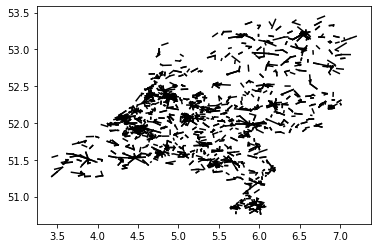

In [6]:
import matplotlib.pyplot as plt
for lon1, lat1, lon2, lat2 in zip(
    ds_overeem_2019.site_a_longitude, 
    ds_overeem_2019.site_a_latitude,
    ds_overeem_2019.site_b_longitude, 
    ds_overeem_2019.site_b_latitude):
    
    plt.plot([lon1, lon2], [lat1, lat2], "-", c="black")

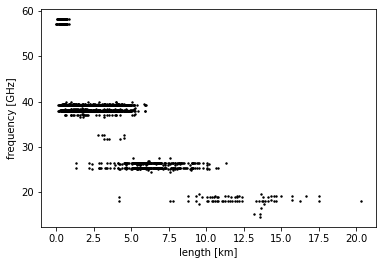

In [7]:
plt.scatter(ds_overeem_2019.length.values,ds_overeem_2019.frequency.values,s=2,color='black')
plt.xlabel("length [km]")
plt.ylabel("frequency [GHz]");

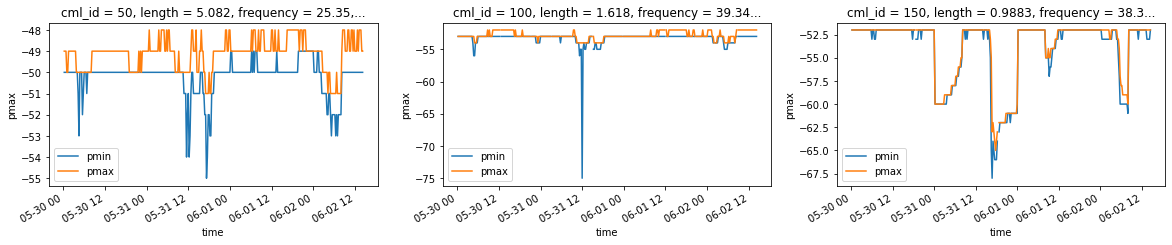

In [8]:
fig,ax=plt.subplots(ncols=3,figsize=(20,3))
for i,j in zip([49,99,149],[0,1,2]):
    ds_overeem_2019.isel(cml_id=i).pmin.plot(label="pmin",ax=ax[j])
    ds_overeem_2019.isel(cml_id=i).pmax.plot(label="pmax",ax=ax[j])
    ax[j].legend()

# Do some basic processing using functions from `pycomlink`

**IMPORTANT NOTE**

This is just a demonstration for running the code. The processing code shown here is not yet adjusted for the 15-minute min-max CML data from the Netherlands.

In [9]:
import sys
sys.path.append('pycomlink')

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tqdm

import pycomlink as pycml

In [11]:
# We create a TRSL, assuming a constant TSL and using `pmin` here.
# Note that this is not the correct way of doing it. This is just
# for demonstrating that the code runs. Results will be wrong.
ds_overeem_2019['trsl'] = 10 - ds_overeem_2019.pmin

## Split up CML dataset to list of individual CMLs for processing 

In [12]:
cml_list = [ds_overeem_2019.isel(cml_id=i) for i in range(len(ds_overeem_2019.cml_id))]

cml = cml_list[0]
cml

<xarray.Dataset>
Dimensions:           (time: 346)
Coordinates:
  * time              (time) datetime64[ns] 2012-05-30T00:15:00 ... 2012-06-0...
    cml_id            int64 1
    length            float64 6.285
    frequency         float64 25.35
    site_a_longitude  float64 3.854
    site_b_longitude  float64 3.775
    site_a_latitude   float64 51.76
    site_b_latitude   float64 51.73
Data variables:
    pmin              (time) float64 -53.0 -53.0 -53.0 -53.0 ... -53.0 -53.0 nan
    pmax              (time) float64 -53.0 -52.0 -53.0 -53.0 ... -51.0 -51.0 nan
    trsl              (time) float64 63.0 63.0 63.0 63.0 ... 63.0 63.0 63.0 nan

## Simple wet-dry classification

Note that this is a method suitabel for 1-minute data and not for the 15-minute data used here. This is just a demonstration of the code.

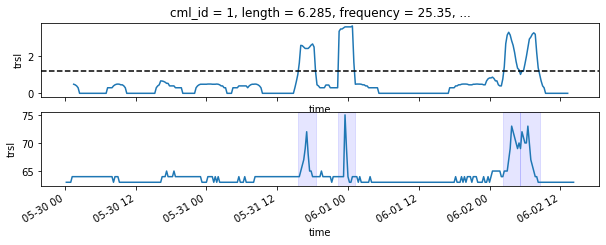

In [13]:
threshold = 1.2

roll_std_dev = cml.trsl.rolling(time=10, center=True).std()
cml['wet'] = cml.trsl.rolling(time=10, center=True).std() > threshold

fig, axs = plt.subplots(2, 1, figsize=(10,3), sharex=True)

roll_std_dev.plot.line(x='time', ax=axs[0])
axs[0].axhline(threshold, color='k', linestyle='--')

cml.trsl.plot.line(x='time', ax=axs[1]);

# Get start and end of dry event
wet_start = np.roll(cml.wet, -1) & ~cml.wet
wet_end = np.roll(cml.wet, 1) & ~cml.wet

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

axs[1].set_title('');

## Do processing of all CMLs 

In [14]:
for cml in tqdm.tqdm(cml_list):
    cml['wet'] = cml.trsl.rolling(time=10, center=True).std(skipna=False) > 1.2

    cml['wet_fraction'] = (cml.wet==1).sum() / len(cml.time)
    
    cml['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=2,
    )

    cml['A'] = cml.trsl - cml.baseline
    cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency,
   )

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1794/2908 [00:14<00:08, 130.47it/s]/Users/chwala-c/code/OPENSENSE_sandbox/pycomlink/pycomlink/processing/k_R_relation.py:57: RuntimeWarning: divide by zero encountered in true_divide
  R[~nan_index & (A >= 0)] = (A[~nan_index & (A >= 0)] / (a * L_km)) ** (1 / b)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2908/2908 [00:22<00:00, 128.84it/s]


## Count those that have a too high wet ratio 

In [15]:
count = 0
for cml in cml_list:
    if cml.wet_fraction > 0.3:
        #print(f'cml_id: {cml.cml_id.values} wet_fraction: {cml.wet_fraction.values}')
        #cml.trsl.plot.line(x='time', figsize=(10,2))
        #plt.show()
        count += 1
print(f'Found {count} CMLs with `wet_fraction` above 30%')

Found 41 CMLs with `wet_fraction` above 30%


## Create 1h-sums 

In [16]:
cml_list_1h = []
for cml in tqdm.tqdm(cml_list):
    if cml.wet_fraction < 0.3:
        cml_list_1h.append(cml.R.resample(time='1h', label='right').mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2908/2908 [01:02<00:00, 46.31it/s]


In [17]:
len(cml_list_1h)

2867

In [18]:
%%time

cmls_R_1h = xr.concat(
    objs=cml_list_1h,
    dim='cml_id',
).to_dataset()

CPU times: user 1.81 s, sys: 19 ms, total: 1.83 s
Wall time: 1.84 s


## Simple IDW interpolation of rainfall sums

Note that the results here are not correct. This just shows how the code is used.

In [19]:
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

In [20]:
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator(
    nnear=6, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.2,
)

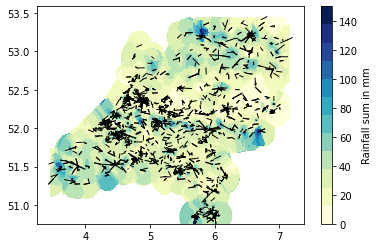

In [22]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

R_grid = idw_interpolator(
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.R.sum(dim='time'), 
    resolution=0.01,
)

fig, ax = plt.subplots()
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap=plt.get_cmap('YlGnBu', 12),
    vmin=0,
    vmax=150,
)
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');